In [25]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [26]:
import os

In [27]:
!pip install keras-unet

In [28]:
import keras
from keras_unet.models import custom_unet

In [29]:
NPYPATH = '/raid/mpsych/RISTERLAB/fly_segmentation_experiments/data_dir/test2/pre_processing/npy/'
MODELPATH = '/raid/mpsych/RISTERLAB/fly_segmentation_experiments/data_dir/test2/pre_processing/models/04-06/'
images_file = os.path.join(NPYPATH, 'original.npy')
labels_file = os.path.join(NPYPATH, 'mask.npy')

In [30]:
images = np.load(images_file)
labels = np.load(labels_file)

In [31]:
images.shape

(1812, 512, 512)

In [32]:
labels.shape

(1812, 512, 512)

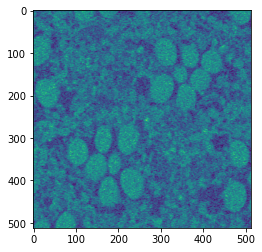

In [33]:
imshow(images[1000])

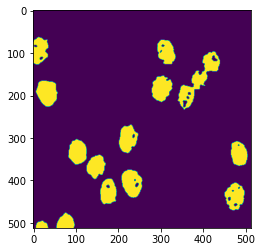

In [34]:
imshow(labels[1000])

In [35]:
images = np.expand_dims(images, axis=3)
labels = np.expand_dims(labels, axis=3)

In [36]:
random_indices = np.random.choice(1812, 200)

In [37]:
training_images = np.empty([200, 512, 512, 1])
training_labels = np.empty([200, 512, 512, 1])
z = 0

for i in random_indices:
    training_images[z] = images[i]
    training_labels[z] = labels[i]
    z = z + 1

In [38]:
training_images.shape

(200, 512, 512, 1)

In [39]:
training_images = training_images.astype(np.float64)
training_labels = training_labels.astype(np.float64)

In [40]:
p = np.random.permutation(len(training_images))

In [41]:
training_images = training_images[p]
training_labels = training_labels[p]

In [42]:
import tensorflow as tf

In [43]:
all_images = []
all_labels = []

for i in range(training_images.shape[0]):
    training_images[i] = (training_images[i] - training_images[i].min()) / (training_images[i].max() - training_images[i].min()) # normalize individually
    
    mask = training_labels[i]
    image = training_images[i]
    
    all_images.append(image)
    all_labels.append(mask)

    image1 = tf.image.flip_left_right(image)
    mask1 = tf.image.flip_left_right(mask)
    
    all_images.append(image1)
    all_labels.append(mask1)
    

    image2 = tf.image.flip_up_down(image)
    mask2 = tf.image.flip_up_down(mask)
    
    all_images.append(image2)
    all_labels.append(mask2)

    image3 = tf.image.rot90(image)
    mask3 = tf.image.rot90(mask)
    
    all_images.append(image3)
    all_labels.append(mask3)

In [44]:
all_images = np.array(all_images).astype(np.float64)
all_labels = np.array(all_labels).astype(np.float64)

In [45]:
all_images.shape

(800, 512, 512, 1)

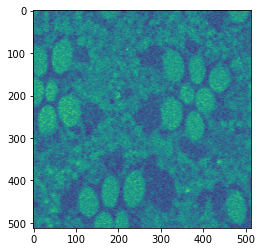

In [46]:
imshow(all_images[100])

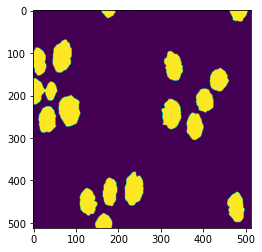

In [47]:
imshow(all_labels[100])

In [48]:
X_train = all_images[0:480]
y_train = all_labels[0:480]
X_val = all_images[480:640]
y_val = all_labels[480:640]
X_test = all_images[640:]
y_test = all_labels[640:]

In [50]:
import keras.optimizers
from keras_unet.metrics import iou, iou_thresholded
from keras_unet.losses import jaccard_distance
from keras.callbacks import ModelCheckpoint

model = custom_unet(
    input_shape=(512, 512, 1),
    use_batch_norm=False,
    num_classes=1,
    filters=32,
    dropout=0.5,
    output_activation='sigmoid')

filepath = (os.path.join(MODELPATH, '04-06-32-200-{epoch:02d}-{val_loss:.2f}.hdf5'))

checkpoint = ModelCheckpoint(filepath,
                             monitor='val_loss', 
                             verbose=1,
                             save_best_only=False,
                             mode='auto', 
                             period=1)

opt = keras.optimizer_v1.Adam(lr=0.01)

model.compile(optimizer = 'Adam',    
              loss='binary_crossentropy', 
              metrics=[iou, iou_thresholded])

history = model.fit(X_train, 
                    y_train, 
                    32, 
                    epochs=200,
                    validation_data=(X_val, y_val), 
                    verbose=1,
                    callbacks=[checkpoint])

2023-04-06 18:40:28.896692: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2023-04-06 18:40:28.917169: I tensorflow/core/platform/profile_utils/cpu_utils.cc:114] CPU Frequency: 2245645000 Hz


Epoch 1/200


2023-04-06 18:40:30.185444: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudnn.so.8
2023-04-06 18:40:31.129735: I tensorflow/stream_executor/cuda/cuda_dnn.cc:359] Loaded cuDNN version 8201
2023-04-06 18:40:32.280828: W tensorflow/stream_executor/gpu/asm_compiler.cc:191] Falling back to the CUDA driver for PTX compilation; ptxas does not support CC 8.0
2023-04-06 18:40:32.280852: W tensorflow/stream_executor/gpu/asm_compiler.cc:194] Used ptxas at ptxas
2023-04-06 18:40:32.281266: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] Unimplemented: ptxas ptxas too old. Falling back to the driver to compile.
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.
2023-04-06 18:40:32.363508: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.11
2023-04-06 18:40:33.436456: I tensorflow/stream_exec

15/15 [==============================] - 18s 370ms/step - loss: 0.7168 - iou: 0.0743 - iou_thresholded: 0.0115 - val_loss: 0.4494 - val_iou: 0.0604 - val_iou_thresholded: 4.1327e-06

Epoch 00001: saving model to /raid/mpsych/RISTERLAB/fly_segmentation_experiments/data_dir/test2/pre_processing/models/04-06/04-06-32-200-01-0.45.hdf5
Epoch 2/200
15/15 [==============================] - 5s 346ms/step - loss: 0.4560 - iou: 0.0441 - iou_thresholded: 9.0004e-05 - val_loss: 0.4911 - val_iou: 0.0773 - val_iou_thresholded: 1.1056e-06

Epoch 00002: saving model to /raid/mpsych/RISTERLAB/fly_segmentation_experiments/data_dir/test2/pre_processing/models/04-06/04-06-32-200-02-0.49.hdf5
Epoch 3/200
15/15 [==============================] - 5s 344ms/step - loss: 0.4307 - iou: 0.0512 - iou_thresholded: 4.5976e-05 - val_loss: 0.4781 - val_iou: 0.0839 - val_iou_thresholded: 1.1056e-06

Epoch 00003: saving model to /raid/mpsych/RISTERLAB/fly_segmentation_experiments/data_dir/test2/pre_processing/models/04-

15/15 [==============================] - 5s 345ms/step - loss: 0.0880 - iou: 0.6258 - iou_thresholded: 0.7334 - val_loss: 0.0876 - val_iou: 0.5486 - val_iou_thresholded: 0.6603

Epoch 00025: saving model to /raid/mpsych/RISTERLAB/fly_segmentation_experiments/data_dir/test2/pre_processing/models/04-06/04-06-32-200-25-0.09.hdf5
Epoch 26/200
15/15 [==============================] - 5s 350ms/step - loss: 0.0874 - iou: 0.6259 - iou_thresholded: 0.7343 - val_loss: 0.0769 - val_iou: 0.5942 - val_iou_thresholded: 0.7292

Epoch 00026: saving model to /raid/mpsych/RISTERLAB/fly_segmentation_experiments/data_dir/test2/pre_processing/models/04-06/04-06-32-200-26-0.08.hdf5
Epoch 27/200
15/15 [==============================] - 5s 346ms/step - loss: 0.0852 - iou: 0.6392 - iou_thresholded: 0.7399 - val_loss: 0.0825 - val_iou: 0.5807 - val_iou_thresholded: 0.6892

Epoch 00027: saving model to /raid/mpsych/RISTERLAB/fly_segmentation_experiments/data_dir/test2/pre_processing/models/04-06/04-06-32-200-27-

15/15 [==============================] - 5s 343ms/step - loss: 0.0618 - iou: 0.7239 - iou_thresholded: 0.8009 - val_loss: 0.0787 - val_iou: 0.5938 - val_iou_thresholded: 0.6782

Epoch 00049: saving model to /raid/mpsych/RISTERLAB/fly_segmentation_experiments/data_dir/test2/pre_processing/models/04-06/04-06-32-200-49-0.08.hdf5
Epoch 50/200
15/15 [==============================] - 5s 343ms/step - loss: 0.0601 - iou: 0.7296 - iou_thresholded: 0.8063 - val_loss: 0.0777 - val_iou: 0.6038 - val_iou_thresholded: 0.6801

Epoch 00050: saving model to /raid/mpsych/RISTERLAB/fly_segmentation_experiments/data_dir/test2/pre_processing/models/04-06/04-06-32-200-50-0.08.hdf5
Epoch 51/200
15/15 [==============================] - 5s 343ms/step - loss: 0.0607 - iou: 0.7291 - iou_thresholded: 0.8037 - val_loss: 0.0764 - val_iou: 0.6125 - val_iou_thresholded: 0.6946

Epoch 00051: saving model to /raid/mpsych/RISTERLAB/fly_segmentation_experiments/data_dir/test2/pre_processing/models/04-06/04-06-32-200-51-

15/15 [==============================] - 5s 349ms/step - loss: 0.0445 - iou: 0.7978 - iou_thresholded: 0.8555 - val_loss: 0.0648 - val_iou: 0.6711 - val_iou_thresholded: 0.7648

Epoch 00073: saving model to /raid/mpsych/RISTERLAB/fly_segmentation_experiments/data_dir/test2/pre_processing/models/04-06/04-06-32-200-73-0.06.hdf5
Epoch 74/200
15/15 [==============================] - 5s 345ms/step - loss: 0.0437 - iou: 0.7972 - iou_thresholded: 0.8573 - val_loss: 0.0658 - val_iou: 0.6965 - val_iou_thresholded: 0.7671

Epoch 00074: saving model to /raid/mpsych/RISTERLAB/fly_segmentation_experiments/data_dir/test2/pre_processing/models/04-06/04-06-32-200-74-0.07.hdf5
Epoch 75/200
15/15 [==============================] - 5s 344ms/step - loss: 0.0441 - iou: 0.7978 - iou_thresholded: 0.8575 - val_loss: 0.0821 - val_iou: 0.6001 - val_iou_thresholded: 0.6941

Epoch 00075: saving model to /raid/mpsych/RISTERLAB/fly_segmentation_experiments/data_dir/test2/pre_processing/models/04-06/04-06-32-200-75-

15/15 [==============================] - 5s 344ms/step - loss: 0.0346 - iou: 0.8383 - iou_thresholded: 0.8871 - val_loss: 0.0589 - val_iou: 0.7407 - val_iou_thresholded: 0.8146

Epoch 00097: saving model to /raid/mpsych/RISTERLAB/fly_segmentation_experiments/data_dir/test2/pre_processing/models/04-06/04-06-32-200-97-0.06.hdf5
Epoch 98/200
15/15 [==============================] - 5s 344ms/step - loss: 0.0313 - iou: 0.8542 - iou_thresholded: 0.8975 - val_loss: 0.0745 - val_iou: 0.6998 - val_iou_thresholded: 0.7529

Epoch 00098: saving model to /raid/mpsych/RISTERLAB/fly_segmentation_experiments/data_dir/test2/pre_processing/models/04-06/04-06-32-200-98-0.07.hdf5
Epoch 99/200
15/15 [==============================] - 5s 351ms/step - loss: 0.0299 - iou: 0.8565 - iou_thresholded: 0.9004 - val_loss: 0.0620 - val_iou: 0.7481 - val_iou_thresholded: 0.8051

Epoch 00099: saving model to /raid/mpsych/RISTERLAB/fly_segmentation_experiments/data_dir/test2/pre_processing/models/04-06/04-06-32-200-99-

15/15 [==============================] - 5s 343ms/step - loss: 0.0242 - iou: 0.8836 - iou_thresholded: 0.9199 - val_loss: 0.0698 - val_iou: 0.7464 - val_iou_thresholded: 0.7793

Epoch 00121: saving model to /raid/mpsych/RISTERLAB/fly_segmentation_experiments/data_dir/test2/pre_processing/models/04-06/04-06-32-200-121-0.07.hdf5
Epoch 122/200
15/15 [==============================] - 5s 343ms/step - loss: 0.0235 - iou: 0.8899 - iou_thresholded: 0.9211 - val_loss: 0.0760 - val_iou: 0.7101 - val_iou_thresholded: 0.7540

Epoch 00122: saving model to /raid/mpsych/RISTERLAB/fly_segmentation_experiments/data_dir/test2/pre_processing/models/04-06/04-06-32-200-122-0.08.hdf5
Epoch 123/200
15/15 [==============================] - 5s 343ms/step - loss: 0.0228 - iou: 0.8890 - iou_thresholded: 0.9226 - val_loss: 0.0703 - val_iou: 0.7706 - val_iou_thresholded: 0.8075

Epoch 00123: saving model to /raid/mpsych/RISTERLAB/fly_segmentation_experiments/data_dir/test2/pre_processing/models/04-06/04-06-32-200

15/15 [==============================] - 5s 345ms/step - loss: 0.0180 - iou: 0.9117 - iou_thresholded: 0.9380 - val_loss: 0.0830 - val_iou: 0.7558 - val_iou_thresholded: 0.7830

Epoch 00145: saving model to /raid/mpsych/RISTERLAB/fly_segmentation_experiments/data_dir/test2/pre_processing/models/04-06/04-06-32-200-145-0.08.hdf5
Epoch 146/200
15/15 [==============================] - 5s 349ms/step - loss: 0.0182 - iou: 0.9103 - iou_thresholded: 0.9371 - val_loss: 0.0816 - val_iou: 0.7674 - val_iou_thresholded: 0.7942

Epoch 00146: saving model to /raid/mpsych/RISTERLAB/fly_segmentation_experiments/data_dir/test2/pre_processing/models/04-06/04-06-32-200-146-0.08.hdf5
Epoch 147/200
15/15 [==============================] - 5s 345ms/step - loss: 0.0176 - iou: 0.9132 - iou_thresholded: 0.9390 - val_loss: 0.0845 - val_iou: 0.7690 - val_iou_thresholded: 0.7983

Epoch 00147: saving model to /raid/mpsych/RISTERLAB/fly_segmentation_experiments/data_dir/test2/pre_processing/models/04-06/04-06-32-200

15/15 [==============================] - 5s 343ms/step - loss: 0.0144 - iou: 0.9279 - iou_thresholded: 0.9493 - val_loss: 0.0883 - val_iou: 0.7937 - val_iou_thresholded: 0.8144

Epoch 00169: saving model to /raid/mpsych/RISTERLAB/fly_segmentation_experiments/data_dir/test2/pre_processing/models/04-06/04-06-32-200-169-0.09.hdf5
Epoch 170/200
15/15 [==============================] - 5s 347ms/step - loss: 0.0143 - iou: 0.9292 - iou_thresholded: 0.9500 - val_loss: 0.0847 - val_iou: 0.7908 - val_iou_thresholded: 0.8116

Epoch 00170: saving model to /raid/mpsych/RISTERLAB/fly_segmentation_experiments/data_dir/test2/pre_processing/models/04-06/04-06-32-200-170-0.08.hdf5
Epoch 171/200
15/15 [==============================] - 5s 344ms/step - loss: 0.0145 - iou: 0.9282 - iou_thresholded: 0.9492 - val_loss: 0.0860 - val_iou: 0.7962 - val_iou_thresholded: 0.8190

Epoch 00171: saving model to /raid/mpsych/RISTERLAB/fly_segmentation_experiments/data_dir/test2/pre_processing/models/04-06/04-06-32-200

15/15 [==============================] - 5s 351ms/step - loss: 0.0132 - iou: 0.9339 - iou_thresholded: 0.9534 - val_loss: 0.0896 - val_iou: 0.8025 - val_iou_thresholded: 0.8196

Epoch 00193: saving model to /raid/mpsych/RISTERLAB/fly_segmentation_experiments/data_dir/test2/pre_processing/models/04-06/04-06-32-200-193-0.09.hdf5
Epoch 194/200
15/15 [==============================] - 5s 344ms/step - loss: 0.0131 - iou: 0.9349 - iou_thresholded: 0.9542 - val_loss: 0.0929 - val_iou: 0.8048 - val_iou_thresholded: 0.8214

Epoch 00194: saving model to /raid/mpsych/RISTERLAB/fly_segmentation_experiments/data_dir/test2/pre_processing/models/04-06/04-06-32-200-194-0.09.hdf5
Epoch 195/200
15/15 [==============================] - 5s 343ms/step - loss: 0.0129 - iou: 0.9359 - iou_thresholded: 0.9547 - val_loss: 0.0870 - val_iou: 0.8192 - val_iou_thresholded: 0.8373

Epoch 00195: saving model to /raid/mpsych/RISTERLAB/fly_segmentation_experiments/data_dir/test2/pre_processing/models/04-06/04-06-32-200

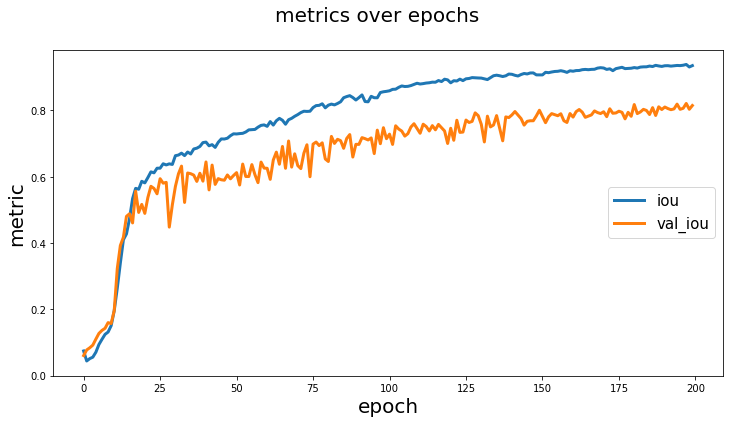

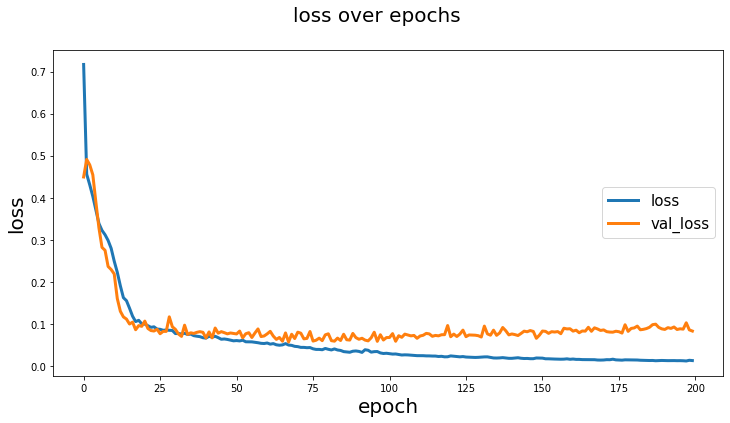

In [51]:
from keras_unet.utils import plot_segm_history

plot_segm_history(history)